In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [33]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [160]:
# Load data into pandas
expert = pd.read_csv("/content/drive/MyDrive/datasets/manual_trajectories/expert.csv")
pgy4 = pd.read_csv("/content/drive/MyDrive/datasets/manual_trajectories/pgy4.csv")
pgy2 = pd.read_csv("/content/drive/MyDrive/datasets/manual_trajectories/pgy2.csv")
trajectories = [expert, pgy4, pgy2]

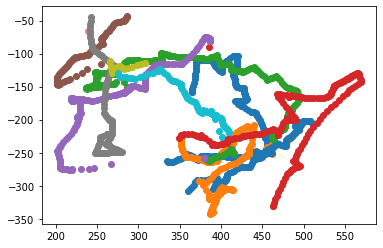

In [ ]:
# Plot PGY2 trajectory
for i in range(max(pgy2['pull']) + 1):
  plt.scatter(pgy2[pgy2['pull'] == i]['x'], pgy2[pgy2['pull'] == i]['y'])

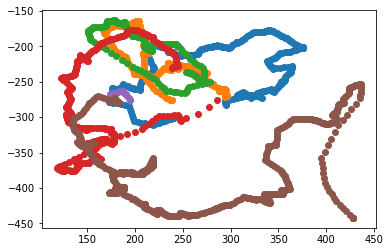

In [ ]:
# Plot PGY4 trajectory
for i in range(max(pgy4['pull']) + 1):
  plt.scatter(pgy4[pgy4['pull'] == i]['x'], pgy4[pgy4['pull'] == i]['y'])

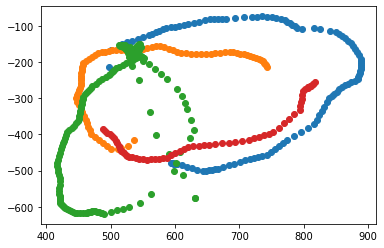

In [ ]:
# Plot expert trajectory
for i in range(max(expert['pull']) + 1):
  plt.scatter(expert[expert['pull'] == i]['x'], expert[expert['pull'] == i]['y'])

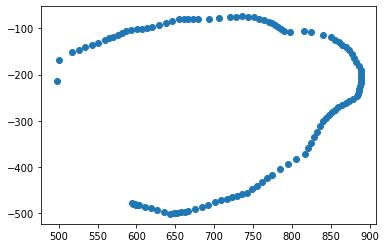

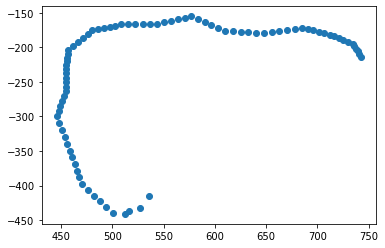

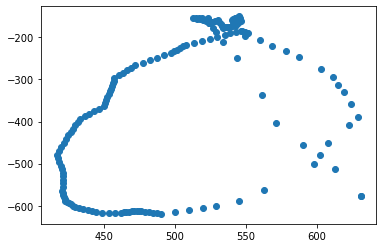

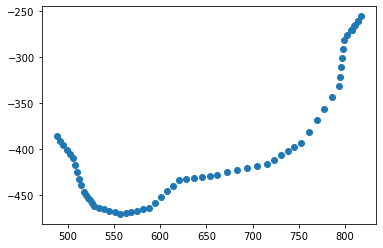

In [ ]:
# Plot all 4 pulls in expert trajectory
for i in range(max(expert['pull']) + 1):
  plt.figure()
  plt.scatter(expert[expert['pull'] == i]['x'], expert[expert['pull'] == i]['y'])
plt.show()

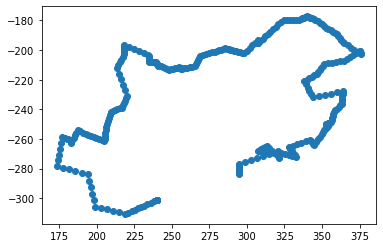

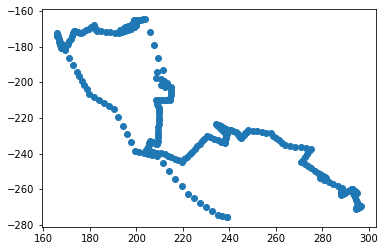

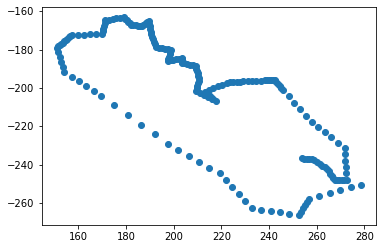

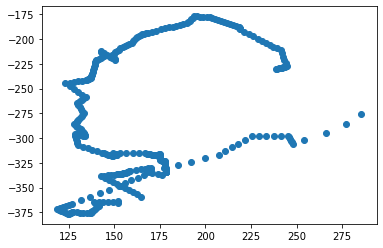

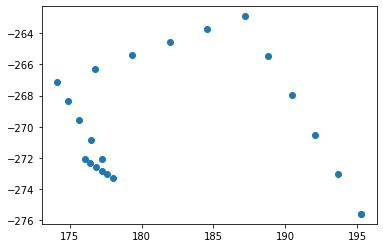

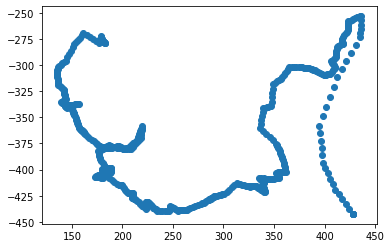

In [ ]:
# Plot all PGY4 trajectories
for i in range(max(pgy4['pull']) + 1):
  plt.figure()
  plt.scatter(pgy4[pgy4['pull'] == i]['x'], pgy4[pgy4['pull'] == i]['y'])
plt.show()

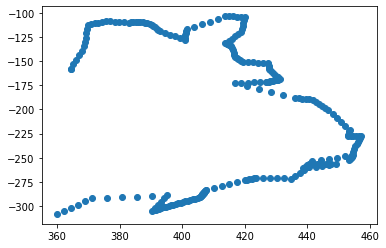

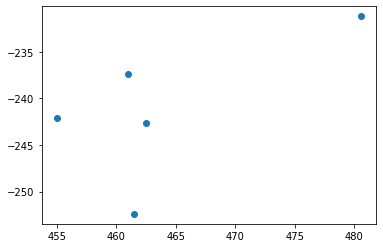

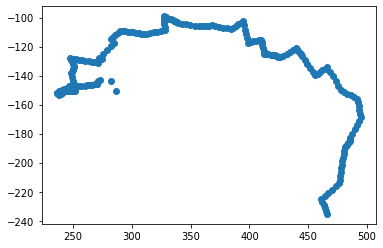

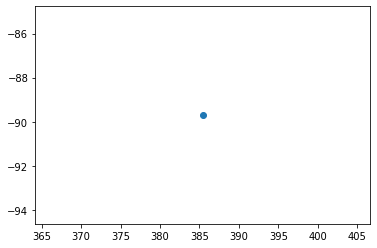

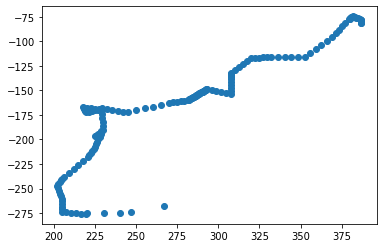

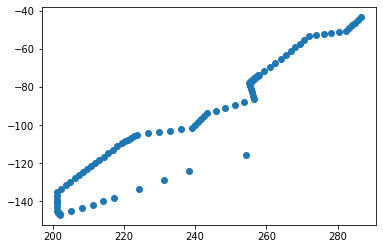

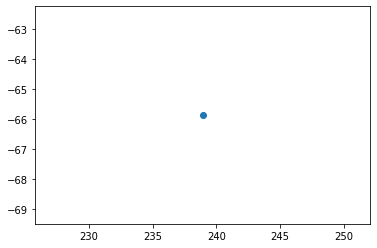

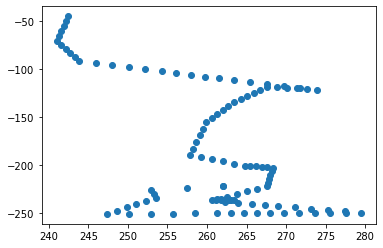

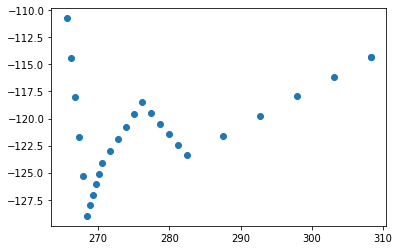

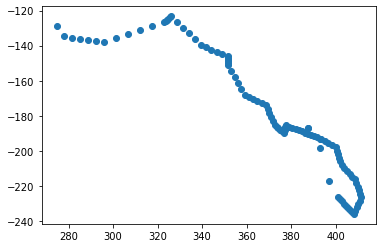

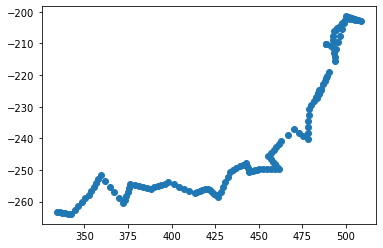

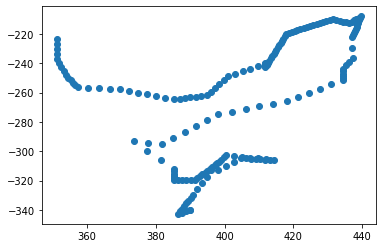

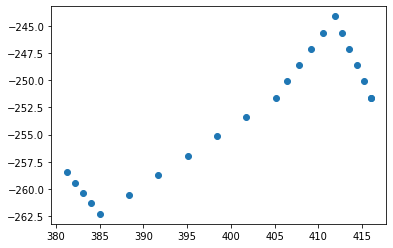

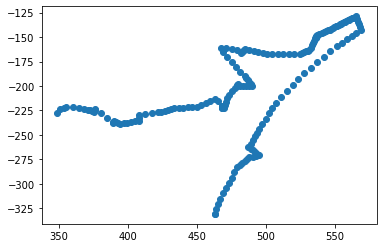

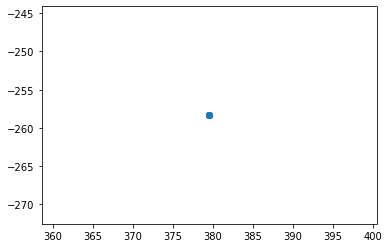

In [ ]:
# Plot all PGY2 trajectories
for i in range(max(pgy2['pull']) + 1):
  plt.figure()
  plt.scatter(pgy2[pgy2['pull'] == i]['x'], pgy2[pgy2['pull'] == i]['y'])
plt.show()

In [79]:
def pull_to_angles(pull):
  """
  Args:
    pull: The dataframe for the pull to convert to angles

  Return:
    angles: The angles for each triple of datapoints
  """
  x, y = pull.x, pull.y
  angles = []
  for i in range(len(x)-2):
    x1, x2, x3 = x[i:i+3]
    y1, y2, y3 = y[i:i+3]
    v1 = np.array([x1-x2, y1-y2])
    v2 = np.array([x3-x2, y3-y2])
    angle_nocos = np.dot(v1, v2) / (np.linalg.norm(v1, 2) * np.linalg.norm(v2, 2))
    angle_floor = np.where(angle_nocos < -1, -1.0, angle_nocos)
    angle_ceil = np.where(angle_floor > 1, 1.0, angle_floor) 
    angle = np.arccos(angle_ceil) * 180 / np.pi
    angles.append(angle)
  return angles

In [81]:
def angles_to_bins(angles):
  """
  Args:
    angles: the list of angles to bin

  Returns:
    histogram: histogram values
    bins: histogram bins
  """
  bins = [i for i in range(0, 181, 5)]
  return np.histogram(angles, bins)


In [94]:
def featurize_pull(pull):
  """
  Performs all featurizations for an individual pull

  Args:
    pull: The pull dataframe to convert to a feature row

  Returns:
    row: A feature row for the pull
  """
  angles = pull_to_angles(pull)
  hist, bins = angles_to_bins(angles)
  return hist

In [103]:
def featurize_trajectory(trajectory, label):
  """
  Splits a trajectory by pulls and featurizes each pull. Each pull is assigned
  the input label.

  Args:
    trajectory: The trajctory dataframe to split into featurized pulls
    label: The label to assign each pull for the trajectory
  
  Return:
    X: The feature rows
    y: The labels for each row
  """
  X = [featurize_pull(df) for val, df in trajectory.groupby('pull')]
  y = np.repeat(label, len(X))
  return np.array(X), y

In [184]:
def featurize_trajectories(trajectories):
  """
  Converts a list of trajectories into a feature matrix and label vector

  Args:
    trajectory: The trajctory dataframe to split into featurized pulls
    label: The label to assign each pull for the trajectory
  
  Return:
    X: The feature matrix
    y: The label vector
  """
  featurized_trajectory_list = [featurize_trajectory(t, i) for i, t in enumerate(trajectories)]
  X = np.row_stack([x for x, y in featurized_trajectory_list])
  y = np.concatenate([y for x, y in featurized_trajectory_list])
  return X, y

In [185]:
X, y = featurize_trajectories(trajectories)
y

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [186]:
from sklearn.model_selection import StratifiedShuffleSplit

# Keep deterministic
np.random.seed(42)
sss = StratifiedShuffleSplit(1, test_size=.2)
train_ind, test_ind =  next(sss.split(X, y))
X_train, X_test = X[train_ind], X[test_ind]
y_train, y_test = y[train_ind], y[test_ind]
# Print to check class balance
y_train, y_test

(array([1, 2, 2, 1, 2, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 0]),
 array([0, 1, 2, 2, 2]))

In [183]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, multi_class="multinomial", max_iter=1000).fit(X_train, y_train)
clf.score(X_test, y_test)

1.0